In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
# import data
df = pd.read_csv('Customer Churn.csv')
df.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


In [4]:
df.shape

(3150, 14)

<Axes: >

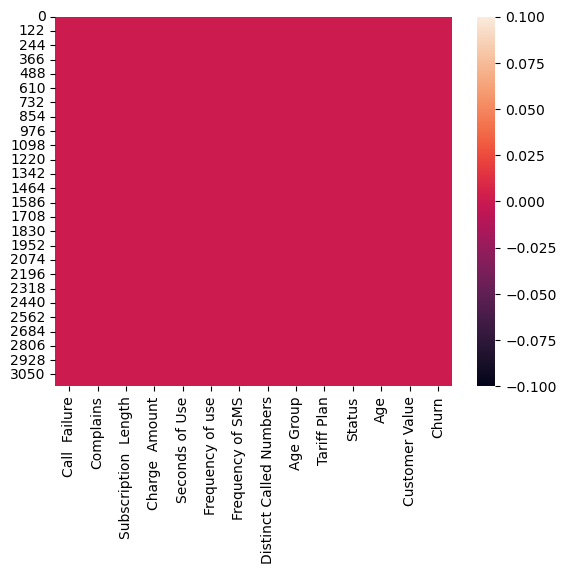

In [5]:
# now see if there are still missing values
sns.heatmap(df.isnull())

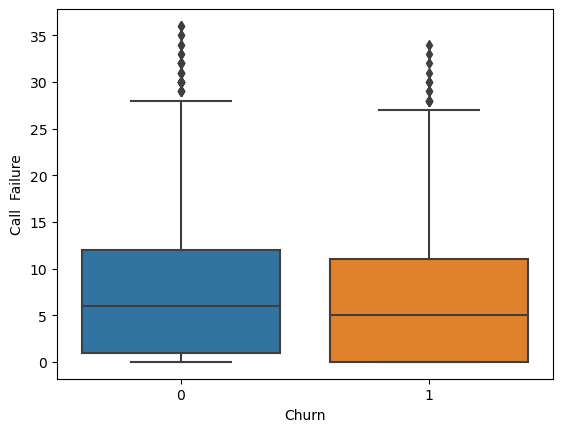

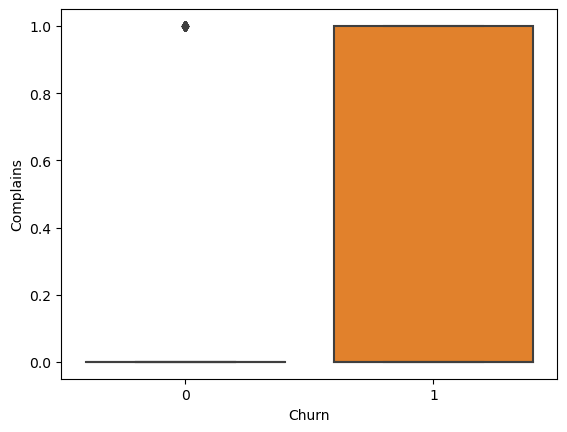

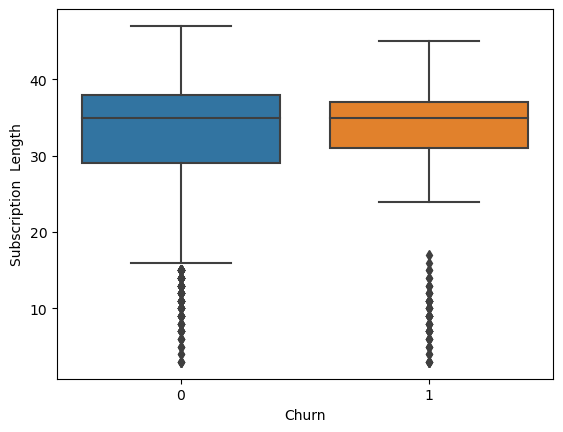

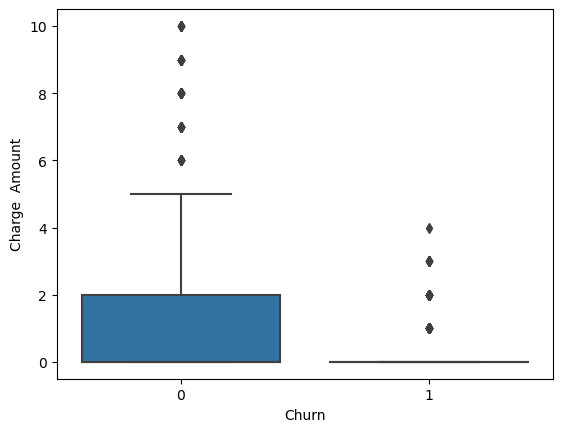

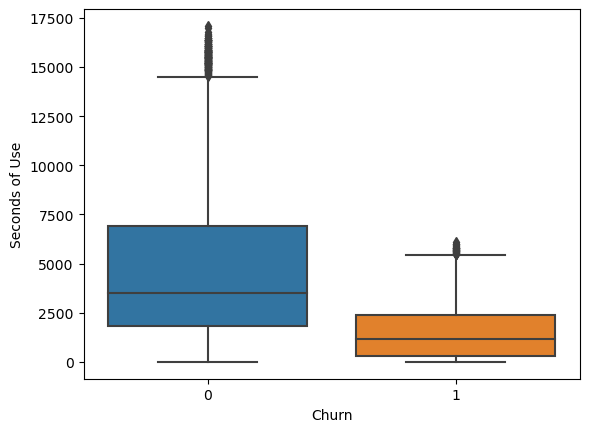

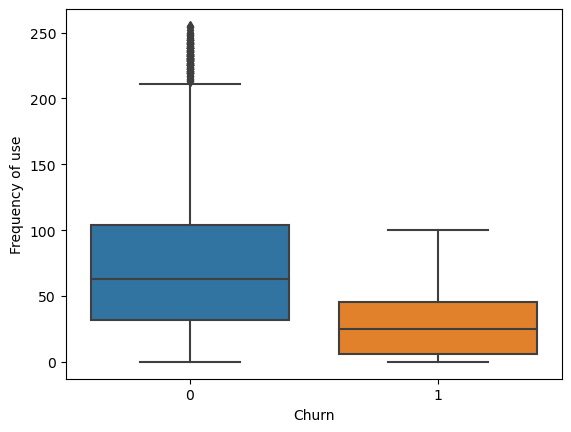

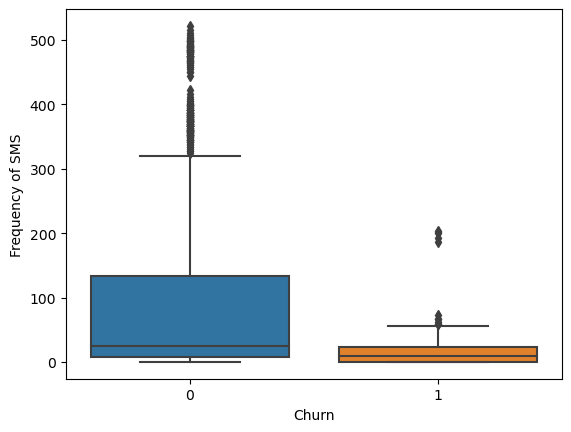

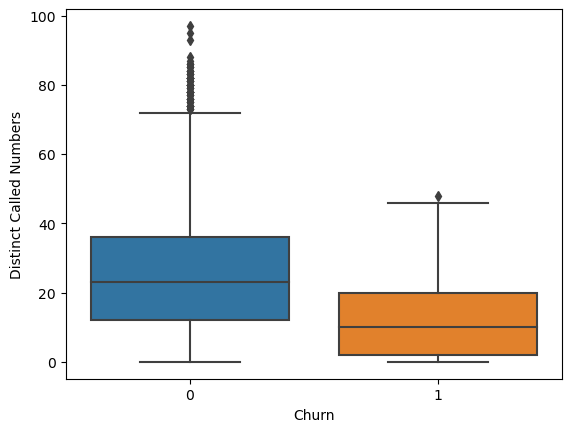

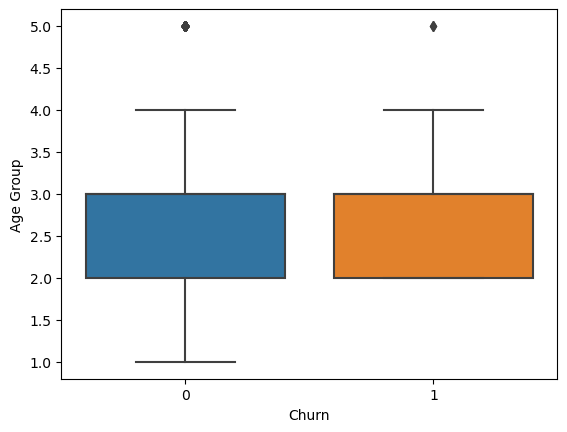

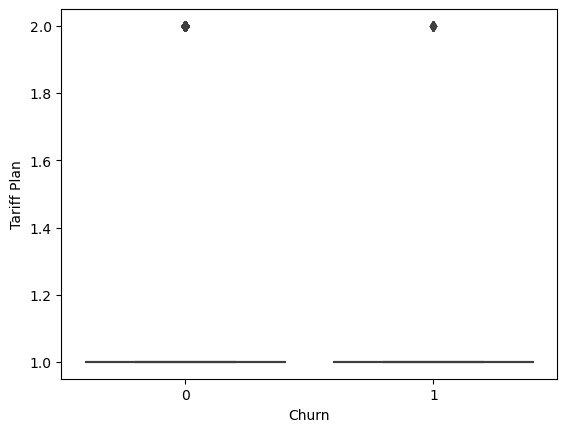

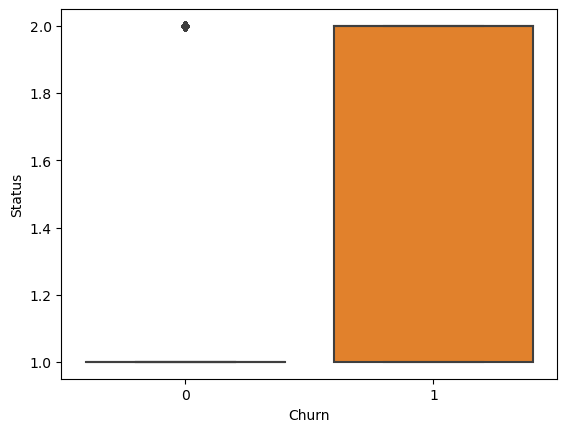

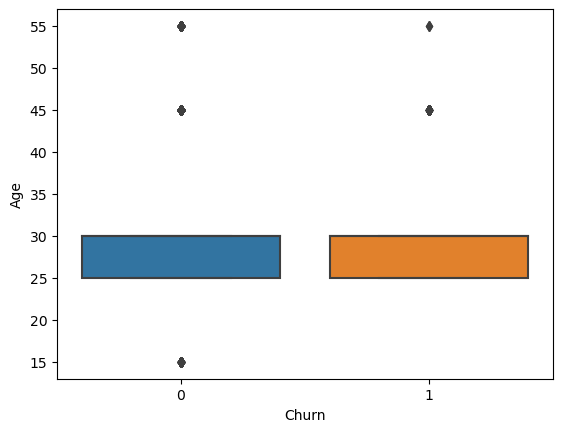

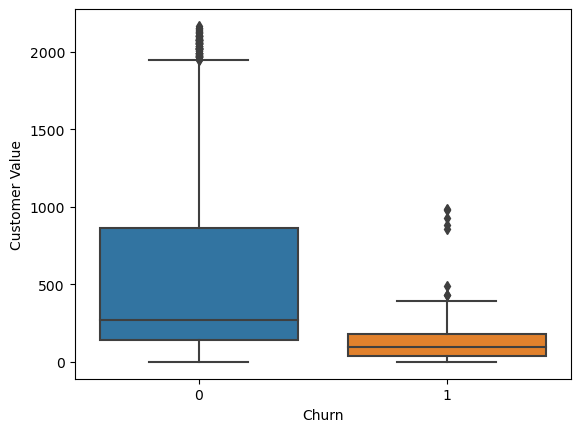

In [6]:
# visually see if there's any effect of the features on Churn
for i, col in enumerate(df.iloc[:,:-1].columns):
    plt.figure(i)
    sns.boxplot(x='Churn', y=col, data=df)

In [7]:
# let's split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.3, random_state=1234)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2205, 13) (945, 13) (2205,) (945,)


In [8]:
# finally let's build the model!
# but one final thing, let's see if the labels are balanced
y_train.value_counts()

Churn
0    1860
1     345
Name: count, dtype: int64

In [9]:
# it's not balanced, with more Nos then Yeses, so let's consider balancing the class weight when we model
# now... the model:

clf = LogisticRegression(class_weight='balanced', random_state=1234).fit(X_train, y_train)

C:\Users\20236190\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
# let's see how it performs on the test set
clf.score(X_test, y_test)

0.7597883597883598

In [11]:
# that's too bad! let's see how each feature contributes to the model
df_features = pd.DataFrame()
df_features['Feature'] = clf.feature_names_in_
df_features['Coefficient'] = abs(clf.coef_[0])
df_features = df_features.sort_values(by=['Coefficient'], ascending=False)
df_features = df_features.reset_index()
df_features

,index,Feature,Coefficient
0,3,Charge Amount,0.402350
1,1,Complains,0.381811
2,10,Status,0.313152
3,0,Call Failure,0.265517
4,6,Frequency of SMS,0.057963
5,5,Frequency of use,0.035975
6,7,Distinct Called Numbers,0.035789
7,9,Tariff Plan,0.034072
8,11,Age,0.033726
9,12,Customer Value,0.010265


In [12]:
# now, what if we just train the model based on abs(coef_) > 0.20?
high_coef_features = df_features[abs(df_features['Coefficient']) > 0.20]['Feature']
high_coef_features

0    Charge  Amount
1         Complains
2            Status
3     Call  Failure
Name: Feature, dtype: object

In [13]:
clf_high = LogisticRegression(class_weight='balanced', random_state=1234).fit(X_train[high_coef_features], y_train)

In [14]:
clf_high.score(X_test[high_coef_features], y_test)

0.8423280423280424

In [15]:
# better!! yayy!!
# maybe let's use normalization in the form a standard scaler where every values are standardized against the mean 
# so scale is standardized across features
clf_std = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced'))

clf_std.fit(X_train[high_coef_features], y_train)

clf_std.score(X_test[high_coef_features], y_test)

0.8423280423280424

In [16]:
# exactly the same!? howabout with just 1 highest coef_ feature: Contract_Month-to-month
clf_std_1 = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced'))

clf_std_1.fit(X_train[['Charge  Amount']], y_train)

clf_std_1.score(X_test[['Charge  Amount']], y_test)

0.5417989417989418

In [17]:
# okay, let's stick with the > 0.20 coefficient features

In [18]:
# okay, maybe high coef feature with standard scaler is enough for now
# now let's put some simulation context into this